In [1]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

import seaborn as sns
import matplotlib.pyplot as plt

# These are all the imports needed for the assignment
%matplotlib inline

# Import nltk package (Natural Language Toolkit)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [2]:
# Download the NLTK English tokenizer and the stopwords of all languages
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
client = boto3.client(
    's3',
    aws_access_key_id = 'sukiK@2002',
    aws_secret_access_key = 'sukik',
    region_name = 'ap-west-1'
)

In [4]:
files = ['amazon_reviews_us_Electronics_v1_00.tsv', \
         'amazon_reviews_us_Gift_Card_v1_00.tsv', \
         'amazon_reviews_us_Major_Appliances_v1_00.tsv', \
         'amazon_reviews_us_Office_Products_v1_00.tsv', \
         'amazon_reviews_us_Shoes_v1_00.tsv', \
         'amazon_reviews_us_Toys_v1_00.tsv', \
         'amazon_reviews_us_Watches_v1_00.tsv']

In [5]:
columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
len(columns)

15

In [6]:
bucket = 'farsdata'
prefix = 'dataFiles'
data_location = 's3://{}/{}/'.format(bucket, prefix)
data_location

's3://farsdata/dataFiles/'

one_file = pd.read_csv(data_location + files[0], names = columns, sep = '\t').iloc[1:,:]
one_file.head()

In [7]:
#test.rename(columns=test.iloc[0])
training_data = pd.DataFrame() #initialize an empty dataframe
testing_data = pd.DataFrame()

one_file = pd.read_csv(data_location + files[1], names = columns, sep = '\t').iloc[1:,:]

In [8]:
one_file.shape

(148310, 15)

In [9]:
def convert_to_int(x):
    return int(float(x))

In [10]:
#convert all mixed datatypes --> string objects (unable to convert to int)
one_file['customer_id'] = one_file['customer_id'].apply(int) #1
one_file['product_parent'] = one_file['product_parent'].apply(int) #4
one_file['star_rating'] = one_file['star_rating'].apply(int) #7
one_file['helpful_votes'] = one_file['helpful_votes'].apply(int) #8
one_file['total_votes'] = one_file['total_votes'].apply(int) #9

In [11]:
one_file.isnull().sum().sort_values(ascending=False)

review_headline      3
review_body          2
review_date          1
verified_purchase    0
vine                 0
total_votes          0
helpful_votes        0
star_rating          0
product_category     0
product_title        0
product_parent       0
product_id           0
review_id            0
customer_id          0
marketplace          0
dtype: int64

In [12]:
one_file.dropna(inplace=True) #drop all of the missing values
one_file.isnull().sum().sort_values(ascending=False)

review_date          0
review_body          0
review_headline      0
verified_purchase    0
vine                 0
total_votes          0
helpful_votes        0
star_rating          0
product_category     0
product_title        0
product_parent       0
product_id           0
review_id            0
customer_id          0
marketplace          0
dtype: int64

for i in range(0, 3):
    print(i)
    model_data = pd.read_csv(data_location + files[i], names = columns, sep = '\t')
    
    train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
    print(train_data.shape, test_data.shape)
    
    training_data.append(train_data, ignore_index=True)
    testing_data.append(test_data, ignore_index=True)

In [13]:
#there may be tabs in the review that is what is leading to the excluded cases when converting to df

'''
train_data['verified_purchase'].value_counts()
test_data['verified_purchase'].value_counts()
'''

one_file.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
1,US,24371595,R27ZP1F1CD0C3Y,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Gift Card,5,0,0,N,Y,Five Stars,Great birthday gift for a young adult.,2015-08-31
2,US,42489718,RJ7RSBCHUDNNE,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,2015-08-31
3,US,861463,R1HVYBSKLQJI5S,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,5,0,0,N,Y,Five Stars,Good,2015-08-31
4,US,25283295,R2HAXF0IIYQBIR,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,1,0,0,N,Y,One Star,Fair,2015-08-31
5,US,397970,RNYLPX611NB7Q,B005ESMGV4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",Gift Card,5,0,0,N,Y,Five Stars,I can't believe how quickly Amazon can get the...,2015-08-31


#to check te datatypes within each column

print(train_data.applymap(type))
data_types = train_data.applymap(type)

In [14]:
#the number of customers that gave multiple reviews
#may be valueable to investigate
one_file.groupby('customer_id').count()['marketplace'].sort_values(ascending = False).value_counts()

1    137085
2      4996
3       320
4        42
5        16
6         2
7         1
Name: marketplace, dtype: int64

In [15]:
one_file['star_rating'].value_counts()

5    129024
4      9807
1      4766
3      3147
2      1560
Name: star_rating, dtype: int64

### Sentiment Analysis

In [16]:
#df is all data other than rating 3
df = one_file[one_file['star_rating'] != 3]

In [17]:
df['star_rating'].value_counts()

5    129024
4      9807
1      4766
2      1560
Name: star_rating, dtype: int64

In [18]:
df['positively_rated'] = np.where(df['star_rating'] > 3, 1, 0)

In [19]:
df['positively_rated'].value_counts()

1    138831
0      6326
Name: positively_rated, dtype: int64

<AxesSubplot:xlabel='positively_rated', ylabel='count'>

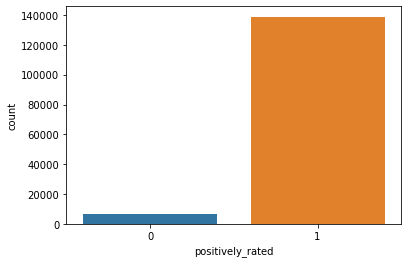

In [20]:
sns.countplot(df['positively_rated'])

##### On all of the data

In [21]:
train_data, test_data = np.split(one_file.sample(frac=1, random_state=1729), [int(0.7 * len(one_file))])
print(train_data.shape, test_data.shape)

(103812, 15) (44492, 15)


In [22]:
X_train = train_data['review_body']
X_train.iloc[0] #to_frame()

'Needed a quick gift for a grandson. The young kids love this kind of gift, they can choose what they want.'

In [23]:
Y_train = train_data['star_rating']

In [24]:
X_test = test_data['review_body']
Y_test = test_data['star_rating']

#### TF-IDF - to get predictions of what star rating will be based on text of review

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
vect = TfidfVectorizer().fit(X_train)

In [27]:
len(vect.get_feature_names()) #unique words

26090

In [28]:
X_train_vect = vect.transform(X_train)

In [29]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vect, Y_train)

LogisticRegression()

In [30]:
predictions = model.predict(vect.transform(X_test))

In [31]:
len(predictions)

44492

###### Confusion Matrix - shows probabilities for whether cat data is predicted correctly

In [32]:
def plot_confusion_matrix(cm, target_names,
                          fname, epoch,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, target=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    plt.style.use('default')

    # # only true if it weren't normalized:
    # accuracy = np.trace(cm) / float(np.sum(cm))
    # misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm[np.isnan(cm)] = 0.0

    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    if target == "rule-based":
        plt.title(title + ' for rule-based PF')
    else:
        plt.title(title + ' for MLPF at epoch ' + str(epoch))

    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlim(-1, len(target_names))
    plt.ylim(-1, len(target_names))
    plt.xlabel('Predicted label')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.savefig(fname + '.png')
    plt.savefig(fname + '.pdf')
    #plt.close(fig)

    return fig, ax

In [33]:
import sklearn

In [34]:
cn = sklearn.metrics.confusion_matrix(Y_test, predictions, labels=None, sample_weight=None, normalize=None)

(<Figure size 500x400 with 2 Axes>,
 <AxesSubplot:title={'center':'0 for MLPF at epoch ConfusionMatrix.png'}, xlabel='Predicted label', ylabel='True label'>)

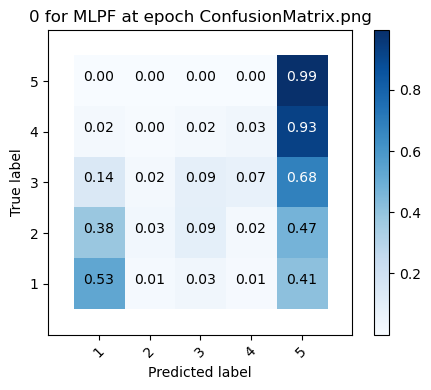

In [35]:
plot_confusion_matrix(cn, [1, 2, 3, 4, 5], "ConfusionMatrixTest", "ConfusionMatrix.png", "0")
#problem where all of the ratings are being predicted as 5

In [36]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()

In [37]:
feature_names[22935]

'terrible'

In [38]:
list(map(lambda x: feature_names[x], sorted_coef_index[:-11:-1]))

['never',
 'not',
 'terrible',
 'tried',
 'waste',
 'charged',
 'unable',
 'horrible',
 'won',
 'poor']

In [39]:
print("smallest coef", list(map(lambda x: feature_names[x], sorted_coef_index[:10])))

smallest coef ['easy', 'great', 'love', 'perfect', 'loved', 'sure', 'like', 'quick', 'convenient', 'nice']


In [40]:
print("largest coef", list(map(lambda x: feature_names[x], sorted_coef_index[:-11:-1])))

largest coef ['never', 'not', 'terrible', 'tried', 'waste', 'charged', 'unable', 'horrible', 'won', 'poor']


### SVM Notes

- **Bag of Words (BoW)**
        - BoW encodes an input sentence as the frequency of each word in the sentence. 
        - In this approach, all words contribute equally to the feature vectors.
- **Term Frequency - Inverse Document Frequency (TF-IDF)**
        - TF-IDF is a measure of how important each term is to a specific document, as compared to an overall corpus. 
        - TF-IDF encodes each word as its frequency in the document of interest, divided by a measure of how common the word is across all documents (the corpus).
        - Using this approach, each word contributes differently to the feature vectors.
        - The assumption behind using TF-IDF is that words that appear commonly everywhere are not that informative about what is specifically interesting about a document of interest, so it is tuned to representing a document in terms of the words it uses that are different from other documents. 

- To compare those 2 methods, we will first apply them on the same dataset to analyse sentiment (how positive or negative a text is). In order to make the comparison fair, an **SVM (support vector machine)** classifier will be used to classify positive reviews and negative reviews.

- SVM is a simple yet powerful and interpretable linear model. To use it as a classifier, we need to have at least 2 splits of the data: training data and test data. The training data is used to tune the weight parameters in the SVM to learn an optimal way to classify the training data. We can then test this trained SVM classifier on the test data, to see how well it works on data that the classifier has not seen before. 

In [41]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,positively_rated
1,US,24371595,R27ZP1F1CD0C3Y,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Gift Card,5,0,0,N,Y,Five Stars,Great birthday gift for a young adult.,2015-08-31,1
2,US,42489718,RJ7RSBCHUDNNE,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,2015-08-31,1
3,US,861463,R1HVYBSKLQJI5S,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,5,0,0,N,Y,Five Stars,Good,2015-08-31,1
4,US,25283295,R2HAXF0IIYQBIR,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,1,0,0,N,Y,One Star,Fair,2015-08-31,0
5,US,397970,RNYLPX611NB7Q,B005ESMGV4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",Gift Card,5,0,0,N,Y,Five Stars,I can't believe how quickly Amazon can get the...,2015-08-31,1


We will now create a CountVectorizer object to transform the text data into vectors with numerical values.

To do so, we will initialize a CountVectorizer object, and name it as vectorizer.

4 arguments to initialize a CountVectorizer:

* analyzer: 'word'
 Specify to analyze data from word-level.
 
* max_features: 2000
 Set a max number of unique words.
 
* tokenizer: word_tokenize
 Set to tokenize the text data by using the word_tokenizer from NLTK .
 
* stop_words: stopwords.words('english')
 Set to remove all stopwords in English. We do this since they generally don't provide useful discriminative information.

In [42]:
vectorizer = CountVectorizer(
    #sublinear_tf=True,
    analyzer='word',
    max_features=2000,
    tokenizer=word_tokenize,
    stop_words=stopwords.words("english")
)

In [43]:
assert vectorizer.analyzer == 'word'
assert vectorizer.max_features == 2000
assert vectorizer.tokenizer == word_tokenize
assert vectorizer.stop_words == stopwords.words('english')
assert hasattr(vectorizer, "fit_transform")

In [44]:
GGR_X = vectorizer.fit_transform(df["review_body"]).toarray()

In [45]:
GGR_Y = df['positively_rated']

Now, we'll instead use sklearn's train_test_split() function here to define our train and test set. Store train data (predictors) into MR_train_X and labels (outcomes) into MR_train_Y. Similarly, store test data into MR_test_X and test labels into MR_test_Y.
- earlier used numpy's np.split in order to replicate this function
- test_size = 0.2 (allocating 20% of data in df to the testing datasets)

In [47]:
GGR_train_X, GGR_test_X, GGR_train_Y, GGR_test_Y = train_test_split(GGR_X, GGR_Y, test_size = 0.2, random_state = 200)
print(GGR_train_X.shape[0])
print(GGR_train_Y.shape[0])

MemoryError: Unable to allocate 1.73 GiB for an array with shape (116125, 2000) and data type int64

In [48]:
#This function will initialize and train a SVM classifier
def train_SVM(X, y, kernel='linear'):
# YOUR CODE HERE
    clf = SVC(kernel = kernel)
    clf.fit(X, y)
    
    return clf

In [49]:
GGR_clf = train_SVM(GGR_train_X, GGR_train_Y)

NameError: name 'GGR_train_X' is not defined

In [ ]:
GGR_predicted_train_Y = MR_clf.predict(GGR_train_X)
GGR_predicted_test_Y = MR_clf.predict(GGR_train_Y)

In [ ]:
print(classification_report(GGR_train_Y,GGR_predicted_train_Y))

In [ ]:
print(classification_report(GGR_test_Y, GGR_predicted_test_Y))